# DIGITAL SIGNAL PROCESSING 2: FEATURE EXTRACTION
Dr. Simon Ruch
 
simon.ruch@uni-tuebingen.de

# FEATURE EXTRACTION: set environment
set python environment

In [1]:
do_installs = True
if do_installs:
    !pip install acoustics
    !pip install numpy
    !pip install scipy
    !pip install matplotlib
    !pip install mne
    !pip install pandas
    !pip install tensorpac
    !pip install requests
    !pip install h5py
    !pip install spikeinterface
    !pip install probeinterface
    !pip install tridesclous
    !pip install ipython
    !pip install ipympl


In [2]:
import acoustics      #=> for creating artificial signals
import numpy as np    #=> for numeric operations
import scipy as sc    #=> for scientific computing
import matplotlib.pyplot as plt #=> for plotting

import mne            #=> for signal processing (M/EEG)
# set browser backend to matplotlib => no popup
mne.viz.set_browser_backend('matplotlib')




import copy           #=> deepcopying

import pandas as pd   #=> for working with data frames

import requests       #=> for downloading data from the web

import h5py           #=> for importing *.h5-files

%matplotlib inline    
                      #=> set plotting backend for notebooks

Using matplotlib as 2D backend.


# FEATURE EXTRACTION
Once the signal is cleaned, we can extract specific features that can be used for further analyses (e.g. machine learning, or statistical testing)

Possible relevant features (to be discussed in the lecture):
* Power spectral density of a channel, segment, ...
* Time-frequency analyses
* Instantaneous phase and power:
  * => Phase-amplitude coupling
  * => Phase coherence
* Measures of coherence/connectivity (in the time-domain, in the spectral domain)
  * => network analyses
* Measures of signal complexity
* Distinct events:
  * High-frequency oscillation bursts
  * Single neuornal spikes
* ...  

Here, we can only touch a few features.

## Power spectral density (PSD)
* A time-series can be described as a sum of oscillations of different frequencies that all have different amplitudes
* Inspecting the different frequency contents (the amplitudes different frequencies have) can provide information about the source from which the signal is recorded.
 
For examples, see previous practical

## Time-frequency analysis (TFA)

Definition: in time-frequency analyses, the signal in the time domain is transformed into the frequency domain for short subsegements of the original signal. This allows exploring how the spectral composition of the signal varies across time.
 
Basic principle:
* Cut the raw data into short (overlapping) segments
* Transform each segment to the frequency domain => PSD
* Assess how the spectral composition varies over time

### Example: synthetic data

Create an artificial signal:
* Sampling rate: 1000 Hz
* Duration: 5s
* Background eeg activity: pink noise
* 10 Hz sine wave burst from 2-3 seconds
* Continuous 20 Hz oscillation
* Chirp starting at 20 Hz with linare increase in frequency

In [3]:
#%% Create artificial data
ieeg = {}
ieeg['srate'] = 1000
ieeg['dur']  = 5
ieeg['time'] = np.arange(0,ieeg['dur']*ieeg['srate'])/ieeg['srate']

ieeg['data'] = []
ieeg['type'] = []

# add some pink-noise
ieeg['type'].append('ieeg')
ieeg['data'].append(acoustics.generator.noise(
    N=len(ieeg['time']),        # 10`000 samples
    color='pink',  
    state=np.random.RandomState(seed=2022) # seed for random numbers generator
    ))

# add 10 Hz sine wave burst
ieeg['data'][0][
    (ieeg['time']>2) & (ieeg['time']<3)] = \
    ieeg['data'][0][(ieeg['time']>2) & (ieeg['time']<3)] +\
    5*np.sin(ieeg['time'][(ieeg['time']>2) & (ieeg['time']<3)]*2*np.pi*10)

# add 20 Hz fixed wave
ieeg['data'][0] = ieeg['data'][0] + 2*np.sin(ieeg['time']*2*np.pi*20)


# add a chirp that linearly increases with frequency
ieeg['data'][0] = ieeg['data'][0] + 2*np.sin(ieeg['time']*2*np.pi*(20+2*ieeg['time']))


Plot the artificial signal

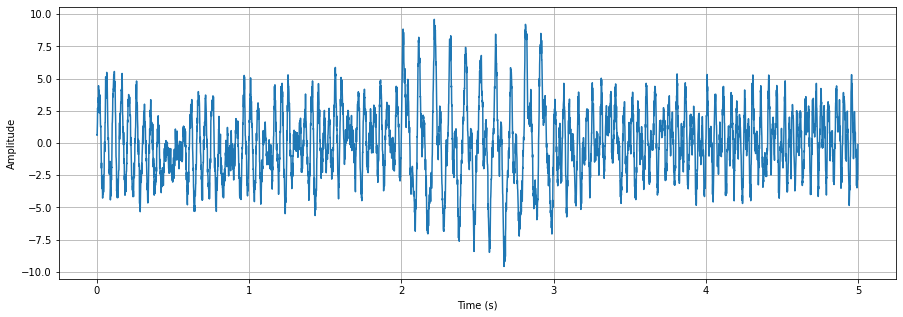

In [4]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ieeg['time'],
       ieeg['data'][0])


ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.grid()

Perform the time-frequency decomposition:
* Perform Morlet wavelet decomposition
* Extract power for frequencies from 1 to 50 Hz at 1 Hz steps
* Number of wavelet cycles per frequency: Frequency/2 (e.g. 0.5 cyles at 1 Hz, 25 cycles at 50 Hz)

In [5]:
# Decompose the signal
ieeg['tfr_freqs'] = np.arange(1,50)         # Frequency resolution of the decomposition
ieeg['tfr_ncycles'] = ieeg['tfr_freqs']/2   # Number of cycles (length of window) for which to compute the power at each frequency

ieeg['tfr'] = mne.time_frequency.tfr_array_morlet(
    epoch_data = ieeg['data'][0][np.newaxis,np.newaxis,:],
    sfreq = ieeg['srate'],
    freqs= ieeg['tfr_freqs'],
    n_cycles=ieeg['tfr_ncycles'])

Plot the decomposition
* all signal components become visible: 20 Hz continuous activity, 10 Hz burst, chirp with increasing frequency from 20 to 40 Hz

/tmp/ipykernel_11717/764831586.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(


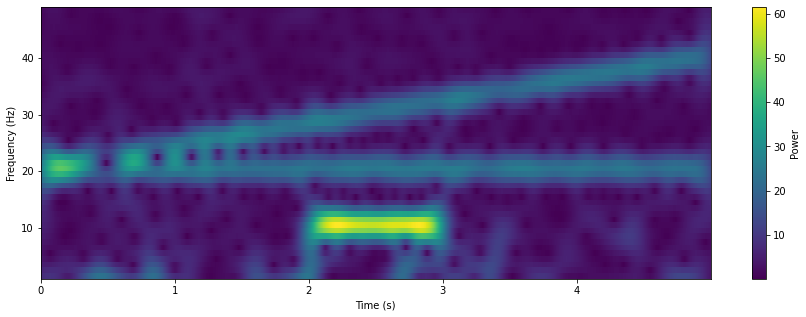

In [6]:
# Plot the decomosition
fig, ax = plt.subplots(figsize= (15,5))

img = ax.pcolormesh(
    ieeg['time'],
    ieeg['tfr_freqs'],
    np.abs(np.squeeze(ieeg['tfr'])))

ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')

cb = plt.colorbar(img, ax=ax)
cb.set_label('Power')

ASSIGNMENT:
* Explore what happens if the frequency resolution is increased/decreased
* Explore what happens if the number of cycles is alters (e.g. fix numer of cycles for all frequencies)

In [7]:
# ASSIGNMENT:
# => hint: modify the following elements of the above code:
#   ieeg['tfr_freqs'] = ...
#   ieeg['tfr_ncycles'] = ...

### Example: real data

Download intracranial eeg data from Fedele et al., 2017, Scientific Reports.
* Data repository: https://openneuro.org/datasets/ds003498/versions/1.0.1
* Original publication: *Fedele T, Burnos S, Boran E, Krayenbühl N, Hilfiker P, Grunwald T, Sarnthein J. Resection of high frequency oscillations predicts seizure outcome in the individual patient. Scientific Reports. 2017;7(1):13836. https://www.nature.com/articles/s41598-017-13064-1 doi:10.1038/s41598-017-13064-1*

Use MNE to process the data:
* https://mne.tools/stable/index.html

In [8]:
import requests


# Dataset: events
url = "https://openneuro.org/crn/datasets/ds003498/snapshots/1.0.1/files/sub-01:ses-interictalsleep:ieeg:sub-01_ses-interictalsleep_run-01_events.tsv"
r = requests.get(url, allow_redirects=True)
open('sub-01_ses-interictalsleep_run-01_events.tsv', 'wb').write(r.content)


# Dataset: channel info
url = "https://openneuro.org/crn/datasets/ds003498/snapshots/1.0.1/files/sub-01:ses-interictalsleep:ieeg:sub-01_ses-interictalsleep_run-01_channels.tsv"
r = requests.get(url, allow_redirects=True)
open('sub-01_ses-interictalsleep_run-01_channels.tsv', 'wb').write(r.content)


# Dataset: header
url = "https://openneuro.org/crn/datasets/ds003498/snapshots/1.0.1/files/sub-01:ses-interictalsleep:ieeg:sub-01_ses-interictalsleep_run-01_ieeg.vhdr"
r = requests.get(url, allow_redirects=True)
open('sub-01_ses-interictalsleep_run-01_ieeg.vhdr', 'wb').write(r.content)

# Dataset: marker
url = "https://openneuro.org/crn/datasets/ds003498/snapshots/1.0.1/files/sub-01:ses-interictalsleep:ieeg:sub-01_ses-interictalsleep_run-01_ieeg.vmrk"
r = requests.get(url, allow_redirects=True)
open('sub-01_ses-interictalsleep_run-01_ieeg.vmrk', 'wb').write(r.content)

# Dataset: eeg
url = "https://openneuro.org/crn/datasets/ds003498/snapshots/1.0.1/files/sub-01:ses-interictalsleep:ieeg:sub-01_ses-interictalsleep_run-01_ieeg.eeg"
r = requests.get(url, allow_redirects=True)
open('sub-01_ses-interictalsleep_run-01_ieeg.eeg', 'wb').write(r.content)



120000000

Import the data using mne:

In [9]:
ieeg = mne.io.read_raw_brainvision('sub-01_ses-interictalsleep_run-01_ieeg.vhdr',preload=True)
ieeg.annotations.crop(0,0)
ieeg.info

Extracting parameters from sub-01_ses-interictalsleep_run-01_ieeg.vhdr...
Setting channel info structure...
Reading 0 ... 599999  =      0.000 ...   300.000 secs...


/tmp/ipykernel_11717/3922152492.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  ieeg = mne.io.read_raw_brainvision('sub-01_ses-interictalsleep_run-01_ieeg.vhdr',preload=True)


<Info | 7 non-empty values
 bads: []
 ch_names: IAR1, IAR2, IAR3, IAR4, IAR5, IAR6, IPR1, IPR2, IPR3, IPR4, ...
 chs: 50 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2013-12-07 08:29:20 UTC
 nchan: 50
 projs: []
 sfreq: 2000.0 Hz
>

Plot first 10 s of raw data of all channels

In [10]:
# set browser backend to matplotlib => no popup
mne.viz.set_browser_backend('matplotlib')

'matplotlib'

Opening raw-browser...


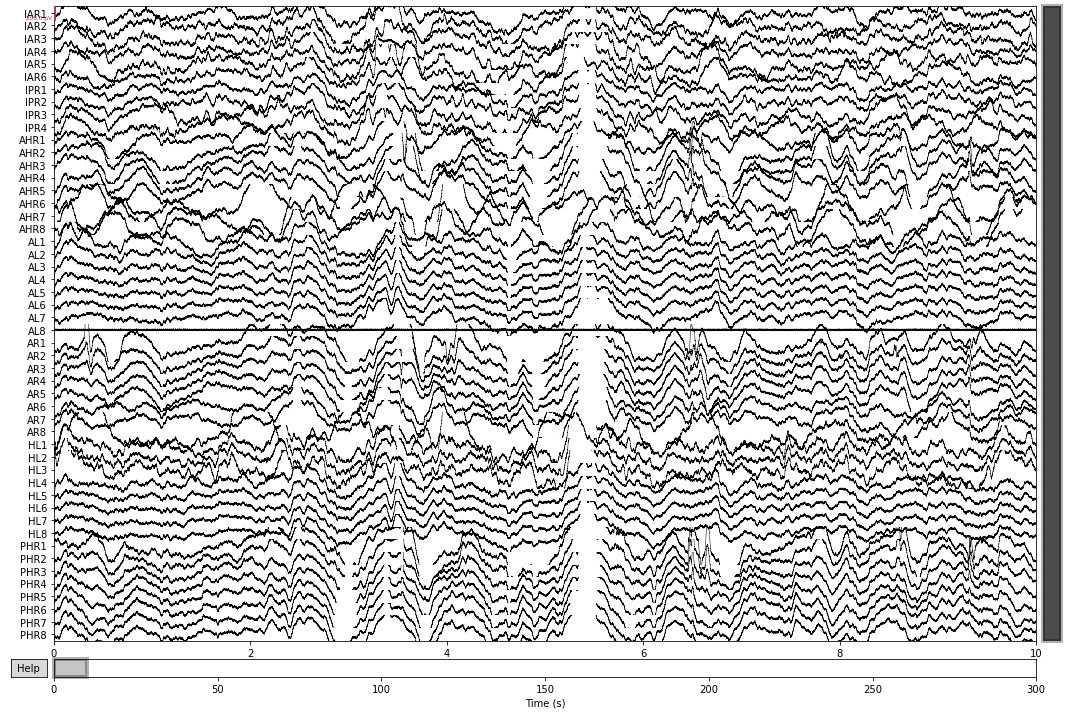

In [11]:
# Plot data
fig = mne.viz.plot_raw(
    ieeg,
    duration=10.0,
    start=0.0,
    n_channels=50,
    show=False,
    scalings={'eeg':0.0001})

fig.set_size_inches(15,10)

Keep only data from macroelectrodes targeting the left amydgala (AL1-8)

In [12]:
ieeg_AL = ieeg.copy().pick_channels(['AL1','AL2','AL3','AL4','AL5','AL6','AL7','AL8'])

Drop channel "AL8":

In [13]:
ieeg_AL.drop_channels('AL8')

<RawBrainVision | sub-01_ses-interictalsleep_run-01_ieeg.eeg, 7 x 600000 (300.0 s), ~32.1 MB, data loaded>

Re-reference the EEG to the common average of all channels:
* Compute the mean of all channels at each sample
* Subtract this mean from each single channel at each sampel
* => this removes the shared information from all channels (shared information: most likely noise)

In [14]:
ieeg_AL.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | sub-01_ses-interictalsleep_run-01_ieeg.eeg, 7 x 600000 (300.0 s), ~32.1 MB, data loaded>

Plot re-referenced data from left amydgala

Opening raw-browser...


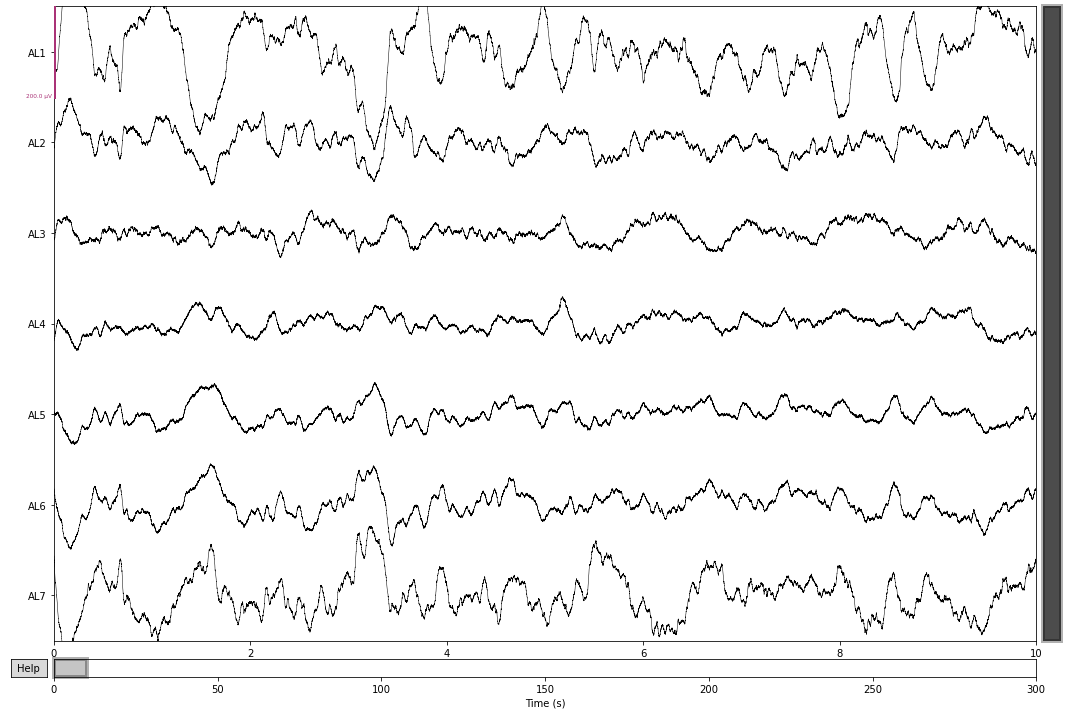

In [15]:
# Plot data
fig = mne.viz.plot_raw(
    ieeg_AL,
    duration=10.0,
    start=0.0,
    n_channels=50,
    show=False,
    scalings={'eeg':0.0001})
fig.set_size_inches(15,10)

Plot PSD for rereferenced data from left amygdala

Effective window size : 2.000 (s)


/tmp/ipykernel_11717/1402638186.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = ieeg_AL.plot_psd(


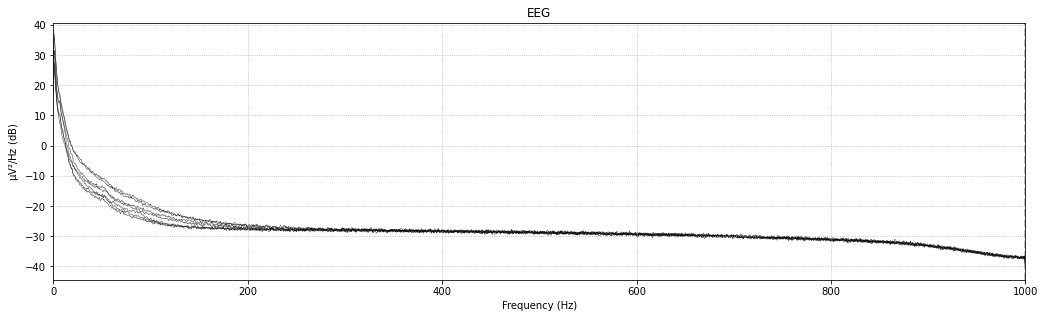

In [16]:
fig = ieeg_AL.plot_psd(
    n_fft = int(2*ieeg_AL.info.get('sfreq')),          # => length of segments: 2* sampling frequency
    n_overlap = int(0.9*2*ieeg_AL.info.get('sfreq')),   # => overlap of segments: 0.9 (90%) of 2s windows
    show=False
)
fig.set_size_inches(15,5)

Subset data:
* Keep only electrode AL1
* Keep only short window of data

In [17]:
ieeg_AL1_window = ieeg_AL.copy().pick_channels(['AL1']).crop(30,60)

Perform the time-frequency decomposition on real data from Amydgala channel AL1:
* Perform Morlet wavelet decomposition
* Extract power for frequencies from 1 to 50 Hz at 1 Hz steps
* Number of wavelet cycles per frequency: Frequency/2 (e.g. 0.5 cyles at 1 Hz, 25 cycles at 50 Hz)
* Normalize the signal: subtract median in each frequency, divide by median absolute deviation (MAD)

In [18]:
# Decompose the signal
AL_dat = {}
AL_dat['tfr_freqs'] = np.arange(1,80,0.5)         # Frequency resolution of the decomposition
AL_dat['tfr_ncycles'] = AL_dat['tfr_freqs']/2   # Number of cycles (length of window) for which to compute the power at each frequency

AL_dat['tfr'] = mne.time_frequency.tfr_array_morlet(
    epoch_data = ieeg_AL1_window.get_data()[np.newaxis,:],
    sfreq = ieeg_AL1_window.info.get('sfreq'),
    freqs= AL_dat['tfr_freqs'],
    n_cycles=AL_dat['tfr_ncycles'],
    output='power')

In [19]:
# Normalize data
AL_dat['tfr'] = np.squeeze(AL_dat['tfr'])
#AL_dat['tfr'] = np.log10(np.squeeze(AL_dat['tfr']))
AL_dat['tfr_mean'] = np.mean(AL_dat['tfr'],axis=1)
AL_dat['tfr_std'] = np.std(AL_dat['tfr'],axis=1)

AL_dat['tfr_stdnorm'] = (AL_dat['tfr']-AL_dat['tfr_mean'][:,None])/AL_dat['tfr_std'][:,None]

AL_dat['tfr_md'] = np.median(AL_dat['tfr'],axis=1)
AL_dat['tfr_mad'] = np.median(np.abs(AL_dat['tfr']-AL_dat['tfr_md'][:,None]),axis = 1)

AL_dat['tfr_madnorm'] = (AL_dat['tfr']-AL_dat['tfr_md'][:,None])/AL_dat['tfr_mad'][:,None]


Plot the decomposition, compare it with the signal in the time domain

/tmp/ipykernel_11717/4103540333.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax[0].pcolormesh(


Text(0.5, 0, 'Time (s)')

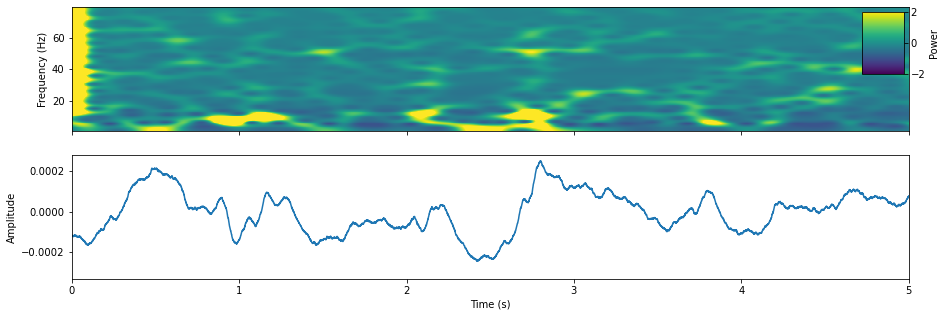

In [20]:
# Plot the decomposition

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(nrows = 2, sharex=True, figsize= (15,5))

img = ax[0].pcolormesh(
    ieeg_AL1_window.times,
    AL_dat['tfr_freqs'],
    np.squeeze(AL_dat['tfr_stdnorm']),
    vmin=-2,
    vmax=2)


ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlim(0,5)

axins = inset_axes(ax[0],
                    width="5%", 
                    height="50%",
                    loc='upper right')


cb = plt.colorbar(img, cax=axins)
cb.set_label('Power')

ax[1].plot(ieeg_AL1_window.times,ieeg_AL1_window.get_data().T)

ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Time (s)')

Assignment: change plot to focus on shorter window and smaller frequency band (e.g. 0-5s, 0-20 Hz)

In [21]:
#Assignment hint: use ax[0].set_xlim() amd ax[0].set_ylim()


## Instantaneous power, phase, (frequency)

Definition: Analysis of the time-resolved (i.e., instantaneous) power and phase of a signal in a specific frequency band. 
 
Possible aplications:
* Assess power fluctuations in a specific frequency range => e.g. is how does beta (20 Hz) power in the motor cortex change during a motor task?
* Assess the specific phase of the signal at a given time => e.g. 
* Assess coherence / connectivity between different channels and or frequencies:
    * e.g. does activity (phase) in the delta band (< 4 Hz) modulate activity in the sigma band (12-16 Hz)?
    * does the connectivity between two brain signals increase? assess signal coherence in the beta range (coherence between beta phase values, correlation between amplitudes, ...)?

### Example

Create an artificial signal:
* Sampling rate: 1000 Hz
* Duration: 5s
* Background eeg activity: pink noise
* 10 Hz sine wave burst from 2-3 seconds
* Continuous 2 Hz oscillation
* 20 Hz oscillatoin that is modulated by 2 Hz oscillation



In [22]:
#%% Create artificial data
ieeg = {}
ieeg['srate'] = 1000
ieeg['dur']  = 5
ieeg['time'] = np.arange(0,ieeg['dur']*ieeg['srate'])/ieeg['srate']

ieeg['data'] = []
ieeg['type'] = []

# add some pink-noise
ieeg['type'].append('ieeg')
ieeg['data'].append(acoustics.generator.noise(
    N=len(ieeg['time']),        # 10`000 samples
    color='pink',  
    state=np.random.RandomState(seed=2022) # seed for random numbers generator
    ))

# add 10 Hz sine wave burst
ieeg['data'][0][
    (ieeg['time']>2) & (ieeg['time']<3)] = \
    ieeg['data'][0][(ieeg['time']>2) & (ieeg['time']<3)] +\
    5*np.sin(ieeg['time'][(ieeg['time']>2) & (ieeg['time']<3)]*2*np.pi*10)

# add 4 Hz fixed wave
ieeg['data'][0] = ieeg['data'][0] + 2*np.sin(ieeg['time']*2*np.pi*2)


# add a chirp that linearly increases with frequency
ieeg['data'][0] = ieeg['data'][0] + 2*np.sin(ieeg['time']*2*np.pi*20)*(1+np.sin(ieeg['time']*2*np.pi*2))


Plot the artificial signal

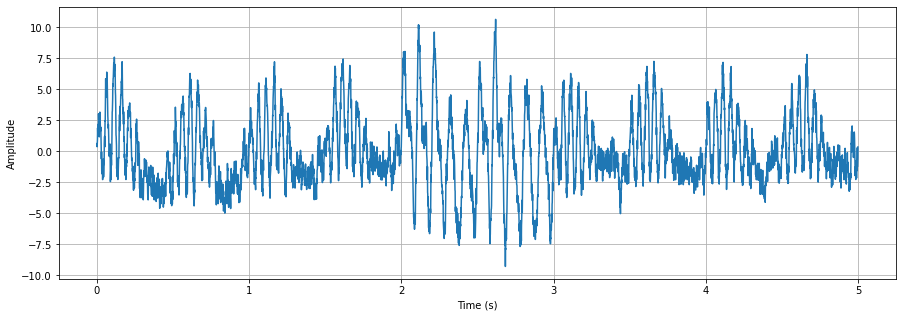

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ieeg['time'],
       ieeg['data'][0])


ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.grid()

Perform the time-frequency decomposition:
* Perform Morlet wavelet decomposition
* Number of wavelet cycles per frequency: Frequency/2 
* Extract power for frequencies from 1 to 50 Hz at 1 Hz steps

In [24]:
# Decompose the signal
ieeg['tfr_freqs'] = np.arange(1,50)         # Frequency resolution of the decomposition
ieeg['tfr_ncycles'] = ieeg['tfr_freqs']/2   # Number of cycles (length of window) for which to compute the power at each frequency

ieeg['tfr'] = mne.time_frequency.tfr_array_morlet(
    epoch_data = ieeg['data'][0][np.newaxis,np.newaxis,:],
    sfreq = ieeg['srate'],
    freqs= ieeg['tfr_freqs'],
    n_cycles=ieeg['tfr_ncycles'])

Plot the decomposition

/tmp/ipykernel_11717/764831586.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(


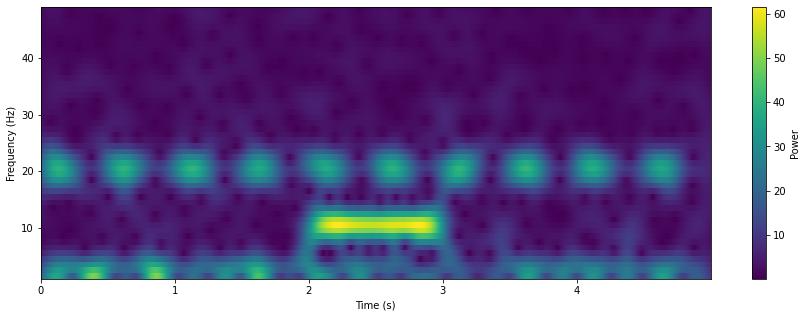

In [25]:
# Plot the decomosition
fig, ax = plt.subplots(figsize= (15,5))

img = ax.pcolormesh(
    ieeg['time'],
    ieeg['tfr_freqs'],
    np.abs(np.squeeze(ieeg['tfr'])))

ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')

cb = plt.colorbar(img, ax=ax)
cb.set_label('Power')

Pefrorm the hilbert transform for 20 Hz oscillations:
* Bandpass filter between 18-22 Hz
* Get the hilbert transform

In [26]:
#%% Hilbert decomposition
sgn_raw     = ieeg['data'][0]
sgn_filt    = mne.filter.filter_data(sgn_raw,
                           sfreq=ieeg['srate'],
                           l_freq = 18,
                           h_freq = 22)

sgn_hilb20   = sc.signal.hilbert(x=sgn_filt)

Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 735 samples (0.735 sec)



Plot the hilbert transform

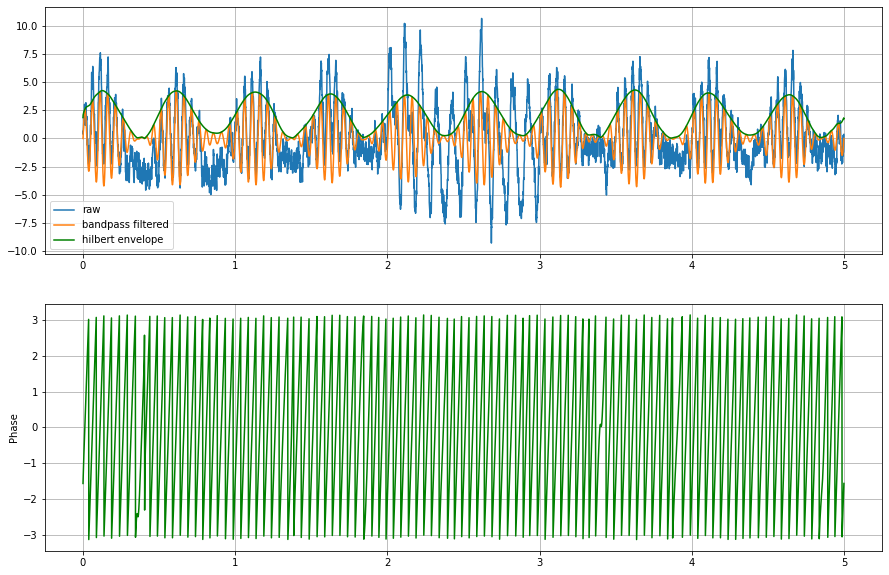

In [27]:
fig, ax = plt.subplots(nrows = 2,figsize=(15,10))

ax[0].plot(ieeg['time'],sgn_raw, label='raw')
ax[0].plot(ieeg['time'],sgn_filt,label='bandpass filtered')
ax[0].plot(ieeg['time'],np.abs(sgn_hilb20),label='hilbert envelope',color='g')
ax[0].legend()
ax[0].grid()


ax[1].set_ylabel('Amplitude')
ax[1].plot(ieeg['time'],np.angle(sgn_hilb20),color='g')
ax[1].set_ylabel('Phase')
ax[1].grid()

Pefrorm the hilbert transform for 2 Hz oscillations:
* Bandpass filter between 1-3 Hz
* Get the hilbert transform

In [28]:
#%% Hilbert decomposition
sgn_raw     = ieeg['data'][0]
sgn_filt    = mne.filter.filter_data(sgn_raw,
                           sfreq=ieeg['srate'],
                           l_freq = 1,
                           h_freq = 3)

sgn_hilb2   = sc.signal.hilbert(x=sgn_filt)

Setting up band-pass filter from 1 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 3.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Filter length: 3301 samples (3.301 sec)



Plot the hilbert transform

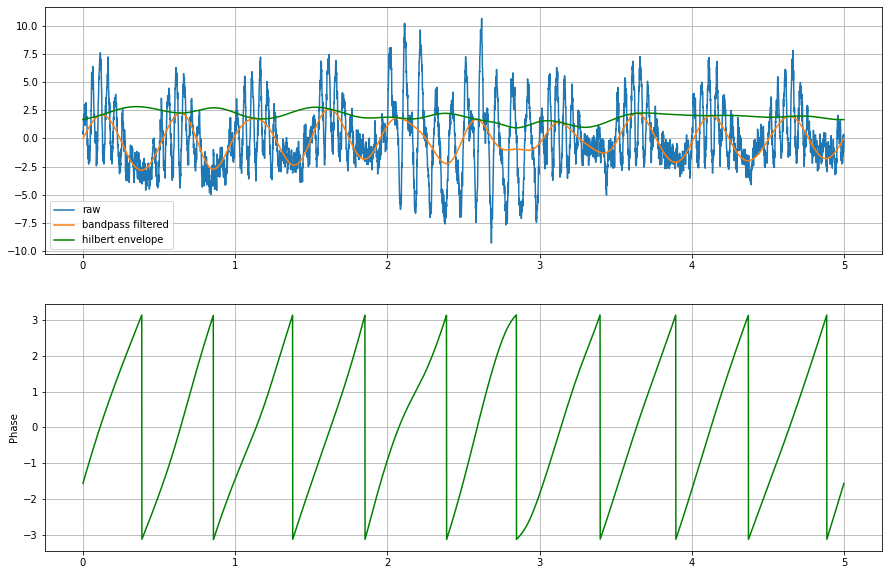

In [29]:
fig, ax = plt.subplots(nrows = 2,figsize=(15,10))

ax[0].plot(ieeg['time'],sgn_raw, label='raw')
ax[0].plot(ieeg['time'],sgn_filt,label='bandpass filtered')
ax[0].plot(ieeg['time'],np.abs(sgn_hilb2),label='hilbert envelope',color='g')
ax[0].legend()
ax[0].grid()


ax[1].set_ylabel('Amplitude')
ax[1].plot(ieeg['time'],np.angle(sgn_hilb2),color='g')
ax[1].set_ylabel('Phase')
ax[1].grid()

## Phase-amplitude coupling
Phase amplitude-coupling describes the phenomenon that the activity (amplitude) of a higher frequency (e.g. 20 Hz) is coupled to a specific phase (e.g. the peak) of a lower freqeuency oscillation (e.g. 2 Hz). The phase of a low frequency oscillation thus appears to modulate the amplitude of a high-frequency oscillation.

Relevance (see Munia & Aviyente, 2019;  https://doi.org/10.1038/s41598-019-48870-2):
* *"Various forms of neural synchrony between oscillations across different frequency bands have been suggested as the major mechanism of neural integration."* 
* *"Previous studies based on electrophysiological measurement of neural activity suggest that different frequency bands are responsible for distinct computational roles as oscillations are thought to create synchronization across specialized brain regions to corroborate cognitive processing."*
* *"The power and/or the synchronization measured across different frequency bands have been related to various cognitive and neuronal functions."*


Further reading:
* Different measures of PAC: *Combrisson, E., Nest, T., Brovelli, A., Ince, R. A. A., Soto, J. L. P., Guillot, A., & Jerbi, K. (2020). Tensorpac: An open-source Python toolbox for tensor-based phase-amplitude coupling measurement in electrophysiological brain signals. PLOS Computational Biology, 16(10), e1008302. https://doi.org/10.1371/journal.pcbi.1008302*
* On the relevance of PAC: *Munia, T. T. K., & Aviyente, S. (2019). Time-frequency based phase-amplitude coupling measure for neuronal oscillations. Scientific Reports, 9(1), 12441. https://doi.org/10.1038/s41598-019-48870-2* 

### Example

Create an artificial signal:
* Sampling rate: 1000 Hz
* Duration: 5s
* Background eeg activity: pink noise
* 10 Hz sine wave burst from 2-3 seconds
* Continuous 2 Hz oscillation
* 20 Hz oscillation that is modulated by 2 Hz oscillation => coupling between 2 Hz phase and 20 Hz amplitude


In [30]:
#%% Create artificial data
ieeg = {}
ieeg['srate'] = 1000
ieeg['dur']  = 5
ieeg['time'] = np.arange(0,ieeg['dur']*ieeg['srate'])/ieeg['srate']

ieeg['data'] = []
ieeg['type'] = []

# add some pink-noise
ieeg['type'].append('ieeg')
ieeg['data'].append(acoustics.generator.noise(
    N=len(ieeg['time']),        # 10`000 samples
    color='pink',  
    state=np.random.RandomState(seed=2022) # seed for random numbers generator
    ))

# add 10 Hz sine wave burst
ieeg['data'][0][
    (ieeg['time']>2) & (ieeg['time']<3)] = \
    ieeg['data'][0][(ieeg['time']>2) & (ieeg['time']<3)] +\
    5*np.sin(ieeg['time'][(ieeg['time']>2) & (ieeg['time']<3)]*2*np.pi*10)

# add 2 Hz fixed wave
ieeg['data'][0] = ieeg['data'][0] + 2*np.sin(ieeg['time']*2*np.pi*2)


# Add a 20 Hz oscillation that is modulated by the phase of the 2 Hz oscillation
ieeg['data'][0] = (ieeg['data'][0] +                    # current data
                   2*np.sin(ieeg['time']*2*np.pi*20)*   # 20 Hz sine wave
                   (1+np.sin(ieeg['time']*2*np.pi*2)))  # Multiplied by amplitude of 2 Hz sine wave


Plot the artificial signal

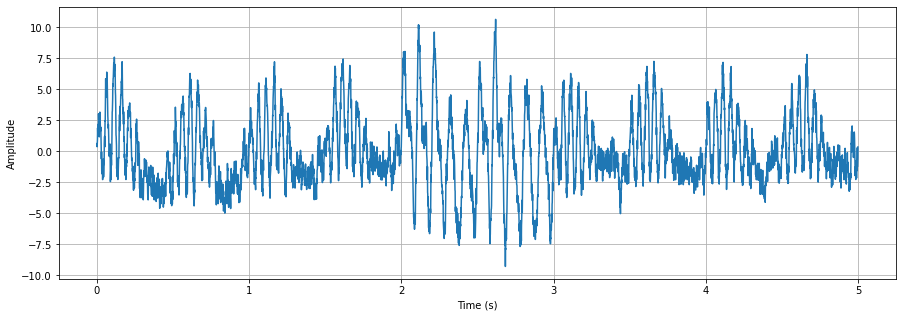

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ieeg['time'],
       ieeg['data'][0])


ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.grid()

Perform the hilbert transform for the 20 Hz, 2 Hz, and 10 Hz band

In [32]:
#%% Hilbert decomposition
sgn_raw     = ieeg['data'][0]

sgn_filt20    = mne.filter.filter_data(sgn_raw,
                           sfreq=ieeg['srate'],
                           l_freq = 18,
                           h_freq = 22)

sgn_hilb20   = sc.signal.hilbert(x=sgn_filt20)

sgn_filt2    = mne.filter.filter_data(sgn_raw,
                           sfreq=ieeg['srate'],
                           l_freq = 1,
                           h_freq = 3)

sgn_hilb2   = sc.signal.hilbert(x=sgn_filt2)

sgn_filt10    = mne.filter.filter_data(sgn_raw,
                           sfreq=ieeg['srate'],
                           l_freq = 8,
                           h_freq = 12)

sgn_hilb10   = sc.signal.hilbert(x=sgn_filt10)


Setting up band-pass filter from 18 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 5.50 Hz (-6 dB cutoff frequency: 24.75 Hz)
- Filter length: 735 samples (0.735 sec)

Setting up band-pass filter from 1 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 3.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Fi

Plot the raw signal, the filtered signal, and the envelopes

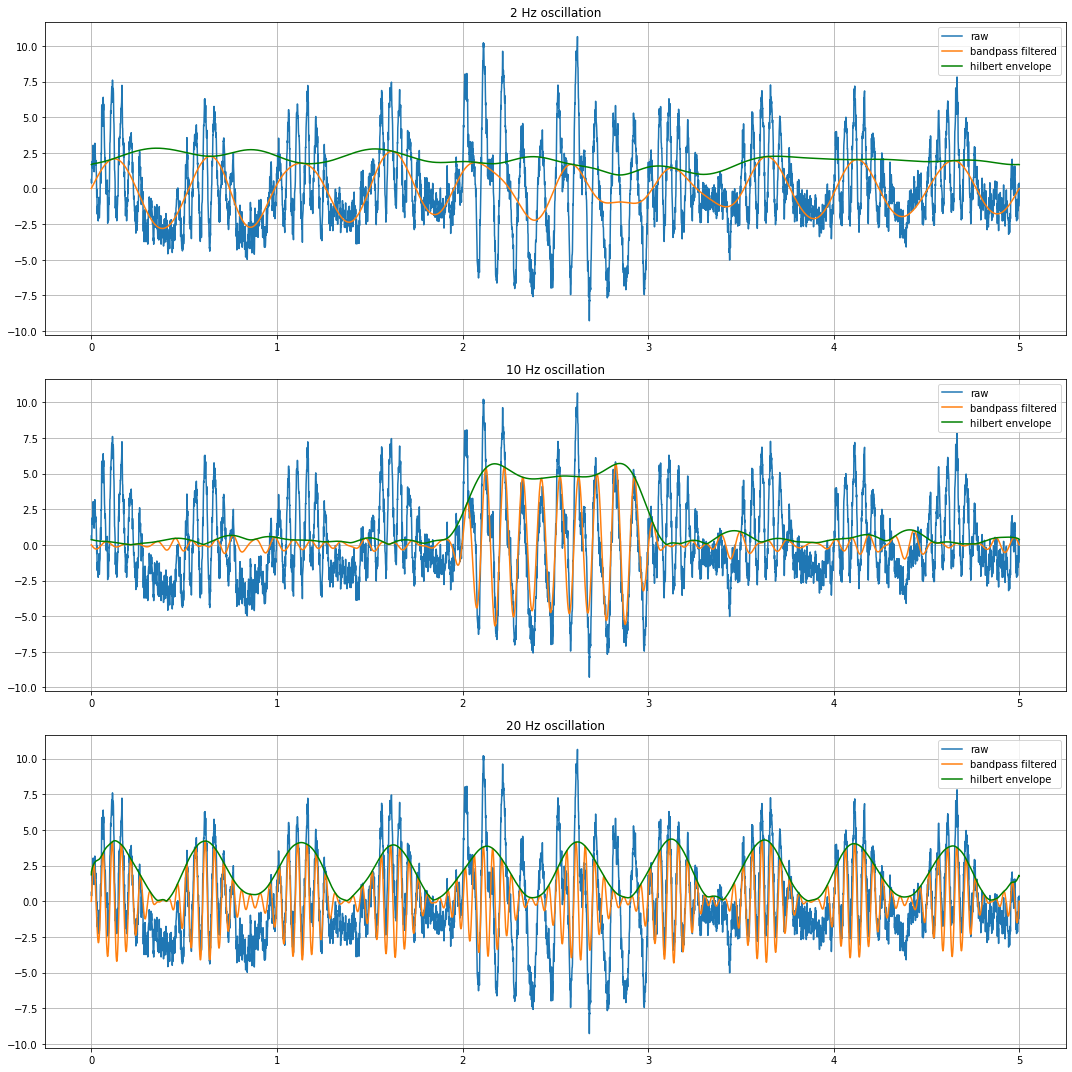

In [33]:
fig, ax = plt.subplots(nrows=3, ncols= 1, figsize=(15,15))
ax[0].plot(ieeg['time'],sgn_raw, label='raw')
ax[0].plot(ieeg['time'],sgn_filt2,label='bandpass filtered')
ax[0].plot(ieeg['time'],np.abs(sgn_hilb2),label='hilbert envelope',color='g')
ax[0].legend()
ax[0].grid()
ax[0].set_title('2 Hz oscillation')

ax[1].plot(ieeg['time'],sgn_raw, label='raw')
ax[1].plot(ieeg['time'],sgn_filt10,label='bandpass filtered')
ax[1].plot(ieeg['time'],np.abs(sgn_hilb10),label='hilbert envelope',color='g')
ax[1].legend()
ax[1].grid()
ax[1].set_title('10 Hz oscillation')



ax[2].plot(ieeg['time'],sgn_raw, label='raw')
ax[2].plot(ieeg['time'],sgn_filt20,label='bandpass filtered')
ax[2].plot(ieeg['time'],np.abs(sgn_hilb20),label='hilbert envelope',color='g')
ax[2].legend()
ax[2].grid()
ax[2].set_title('20 Hz oscillation')

fig.tight_layout()

Assess how activity at 10 Hz and 20 Hz is coupled to the 2 Hz phase
* Bandpasss filter the signal in the respective frequency bans
* Extract the instantaneous 2 Hz phase angles and 10 Hz and 20 Hz amplitude for each samples
* Assess the coupling between the 2 Hz phase angles and the 10/20 Hz values

Make a data frame with the amplitude values at 10 Hz and 20 Hz and the phase angles at 2 Hz for each sample:

In [34]:
phase_amp_data = pd.DataFrame(
    {
        'phase2Hz': np.angle(sgn_hilb2),
        'amp20Hz':np.abs(sgn_hilb20),
        'amp10Hz':np.abs(sgn_hilb10)}
)

Group the phase angles into 24 equally sized bins

In [35]:
phase_amp_data['phase2Hz_bin'] = pd.cut(phase_amp_data['phase2Hz'],24)
phase_amp_data['phase2Hz_bincentres'] = phase_amp_data['phase2Hz_bin'].apply(lambda x: x.mid)
phase_amp_data

,phase2Hz,amp20Hz,amp10Hz,phase2Hz_bin,phase2Hz_bincentres
0,-1.570796,1.858320,0.367373,"(-1.832, -1.571]",-1.7015
1,-1.555456,2.090646,0.371470,"(-1.571, -1.309]",-1.4400
2,-1.540155,2.135187,0.363878,"(-1.571, -1.309]",-1.4400
3,-1.525022,2.229085,0.362326,"(-1.571, -1.309]",-1.4400
4,-1.509828,2.267196,0.356706,"(-1.571, -1.309]",-1.4400
...,...,...,...,...,...
4995,-1.626048,1.715370,0.430232,"(-1.832, -1.571]",-1.7015
4996,-1.612174,1.761613,0.425062,"(-1.832, -1.571]",-1.7015
4997,-1.598442,1.762300,0.414002,"(-1.832, -1.571]",-1.7015
4998,-1.584595,1.822797,0.407230,"(-1.832, -1.571]",-1.7015


Compute the mean amplitudes at 10 Hz and 20 Hz for each 2 Hz bin. Normalize the amplitudes in each bin by the sum of of the amplitudes from all bins.

In [36]:
phase_amp_data_aggr = phase_amp_data.groupby('phase2Hz_bincentres').mean().reset_index()
phase_amp_data_aggr['amp10Hz']= phase_amp_data_aggr['amp10Hz']/sum(phase_amp_data_aggr['amp10Hz'])
phase_amp_data_aggr['amp20Hz']= phase_amp_data_aggr['amp20Hz']/sum(phase_amp_data_aggr['amp20Hz'])
phase_amp_data_aggr



,phase2Hz_bincentres,phase2Hz,amp20Hz,amp10Hz
0,-3.013500,-3.011027,0.004951,0.062912
1,-2.748500,-2.748252,0.007916,0.051070
2,-2.487000,-2.488079,0.013656,0.045891
3,-2.225000,-2.225834,0.021031,0.041093
4,-1.963000,-1.963471,0.028762,0.037941
5,-1.701500,-1.701149,0.037366,0.033893
6,-1.440000,-1.439143,0.047415,0.031967
7,-1.178000,-1.177680,0.056267,0.029361
8,-0.916000,-0.916871,0.064041,0.027282
9,-0.654000,-0.655559,0.070692,0.028848


Quantify phase amplitude coupling:
* If the 2 Hz oscillation modulates the amplitude of the high-frequency oscillation, high-frequency amplitudes should be significantly higher in specific phase bins of the 2 Hz oscillation
* This bias towards a phase can be expressed as "MODULATION INDEX": the amplitude of the mean vector computed over all phases and their amplitudes. 

Compute the mean vector as complex number:

In [37]:
MI_2hzX10Hz = np.mean(
    phase_amp_data_aggr['amp10Hz'].to_numpy()*np.exp(1j*phase_amp_data_aggr['phase2Hz_bincentres'].to_numpy()))

MI_2hzX20Hz = np.mean(
    phase_amp_data_aggr['amp20Hz'].to_numpy()*np.exp(1j*phase_amp_data_aggr['phase2Hz_bincentres'].to_numpy()))



Plot amplitudes in each phase on polar coordinate system, add mean vector

Text(0.5, 1.0, 'Mean 10 Hz amplitude by 2 Hz phase')

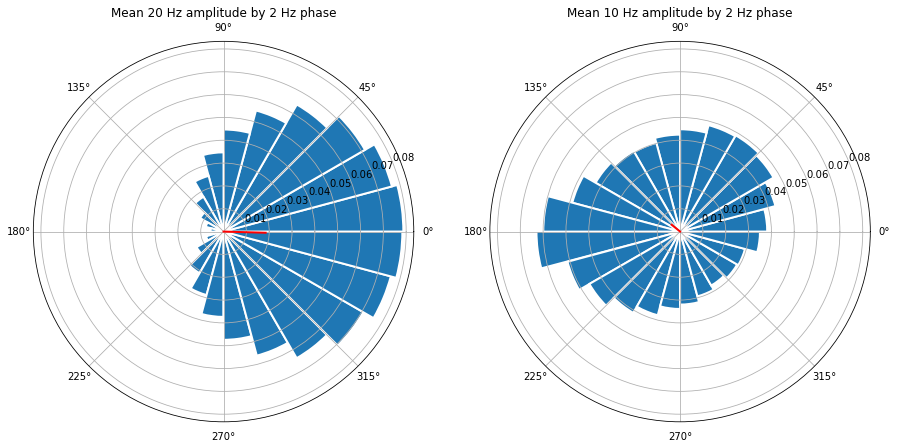

In [38]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(121, projection='polar')

ax.bar(x=phase_amp_data_aggr['phase2Hz_bincentres'],
       height=phase_amp_data_aggr['amp20Hz'],
      width=2*np.pi/24,
       linewidth=2, 
       edgecolor="white")
ax.plot([0,np.angle(MI_2hzX20Hz)],
        [0,np.abs(MI_2hzX20Hz)],'r',linewidth=2)
ax.set_title('Mean 20 Hz amplitude by 2 Hz phase')
ax.set_ylim(0,1/12)


ax = fig.add_subplot(122, projection='polar')
ax.bar(x=phase_amp_data_aggr['phase2Hz_bincentres'],
       height= phase_amp_data_aggr['amp10Hz'],
       width=2*np.pi/24,
       linewidth=2, 
       edgecolor="white")
ax.plot([0,np.angle(MI_2hzX10Hz)],
        [0,np.abs(MI_2hzX10Hz)],'r',linewidth=2)
ax.set_ylim(0,1/12)

ax.set_title('Mean 10 Hz amplitude by 2 Hz phase')

### Comodulogram: PAC over range of frequencies
The comodulogram illustrates phase-amplitude coupling between phases of an entire range of frequencies (e.g. 1-6 Hz) and amplitudes of an entire range of frequencies (e.g. 7-40 Hz)
 
The package "tensorpac" (https://etiennecmb.github.io/tensorpac/) provides efficient and robust methods for PAC analyses.



Compute comodulogram for artificial data:

Phase Amplitude Coupling object defined
    extract phases (n_pha=45) and amplitudes (n_amps=66)
    true PAC estimation using Gaussian Copula PAC (gcPac)


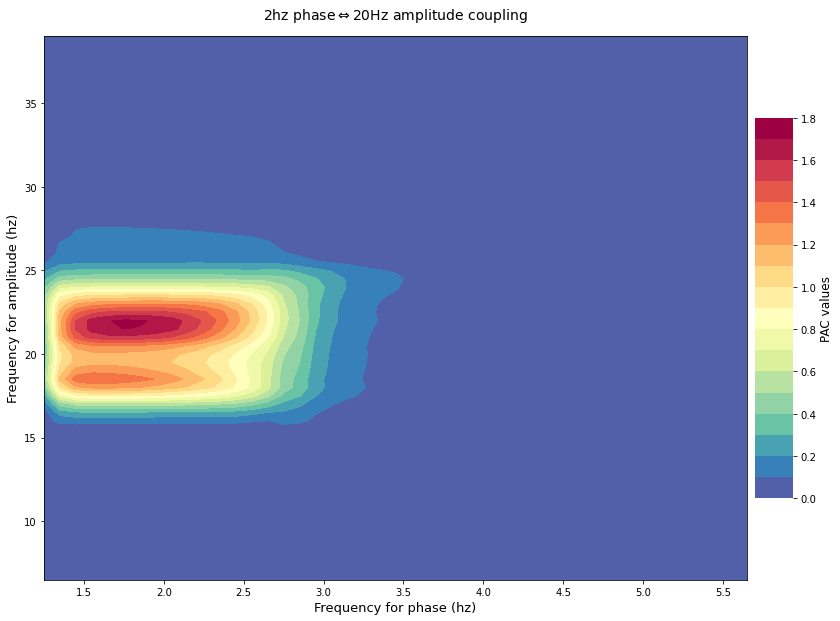

In [39]:
import tensorpac

# Define a Pac object
p = tensorpac.Pac(idpac=(6,0,0), f_pha=(1,6,0.5,0.1), f_amp=(6,40,1,0.5))
# Filter the data and extract pac
xpac = p.filterfit(1000, sgn_raw)

# Prpare figure
fig, ax = plt.subplots(figsize=(15,10))


# plot Phase-Amplitude Coupling :
ax = p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=20,
               title=r'2hz phase$\Leftrightarrow$20Hz amplitude coupling',
               fz_title=14, fz_labels=13)

p.show()

Compute comodulogram data from the Amygdala ('AL1'):
* coupling between 1 Hz phase and 20 Hz amplitudes
* coupling between 2.5 Hz phase and 25 Hz amplitudes

Phase Amplitude Coupling object defined
    extract phases (n_pha=8) and amplitudes (n_amps=88)
    true PAC estimation using Gaussian Copula PAC (gcPac)


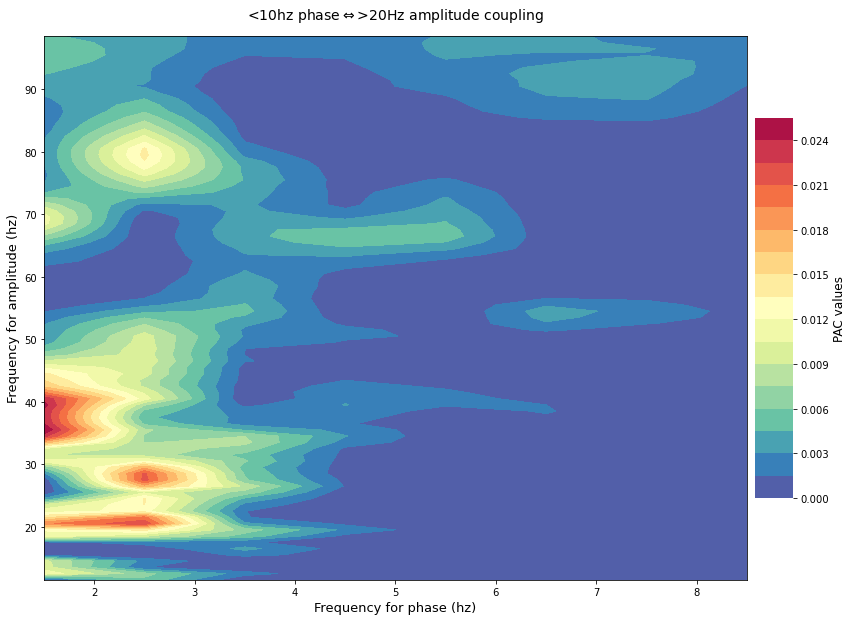

In [40]:
# Define a Pac object
p = tensorpac.Pac(idpac=(6,0,0), f_pha=(1,10,1,1), f_amp=(11,100,1,1))
# Filter the data and extract pac
xpac = p.filterfit(ieeg_AL1_window.info.get('sfreq'), ieeg_AL1_window.get_data(0))

# Prpare figure
fig, ax = plt.subplots(figsize=(15,10))


# plot Phase-Amplitude Coupling :
ax = p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=20,
               title=r'<10hz phase$\Leftrightarrow$>20Hz amplitude coupling',
               fz_title=14, fz_labels=13)

p.show()

## Spike detection and spike sorting

### Load data

Download example data that is used in the tutorials for the (outdated) SpikeSort package
* Package: https://spike-sort.readthedocs.io
* Tutorial data: https://spike-sort.readthedocs.io/en/latest/datafiles.html#tutorial-data

Dataset:
* Reference: *Telenczuk, Bartosz, Stuart N Baker, Andreas V M Herz, and Gabriel Curio. “High-frequency EEG Covaries with Spike Burst Patterns Detected in Cortical Neurons.” Journal of Neurophysiology 105, no. 6 (2011): 2951–2959.*
* Data:
    * 4 channels recorded in macacques
    * sampling-rate: 25 kHz
    * Recording: 15.675 minutes of data


In [71]:
# Donload the data
url = "https://github.com/btel/SpikeSort/releases/download/v0.12/tutorial.h5"
r = requests.get(url, allow_redirects=True)
open('microelectrode_data.h5','wb').write(r.content)

188913976

In [72]:
# Load the dataset
import h5py
# sampling rate: 25000 Hz
# 4 Channels
# 15.675 minutes of recording

f = h5py.File('microelectrode_data.h5')
dset = f['SubjectA']['session01']['el1']['raw'][:]
print('Dimension:')
print(dset.shape)
print('Duration in minutes: ' + str(dset.shape[1]/25000/60))

Dimension:
(4, 23512500)
Duration in minutes: 15.675


### Preprocess data

Cut the date to 5 minutes

In [73]:
dset = dset[:,10*60*25000:15*60*25000]

Create a mne dataset

In [74]:
dset_info = mne.create_info(ch_names=['ch0','ch1','ch2','ch3'],ch_types=4*['eeg'], sfreq=25000)
dset_mne = mne.io.RawArray(dset,dset_info)

Creating RawArray with float64 data, n_channels=4, n_times=7500000
    Range : 0 ... 7499999 =      0.000 ...   300.000 secs
Ready.


Plot raw data: 5 seconds

Opening raw-browser...


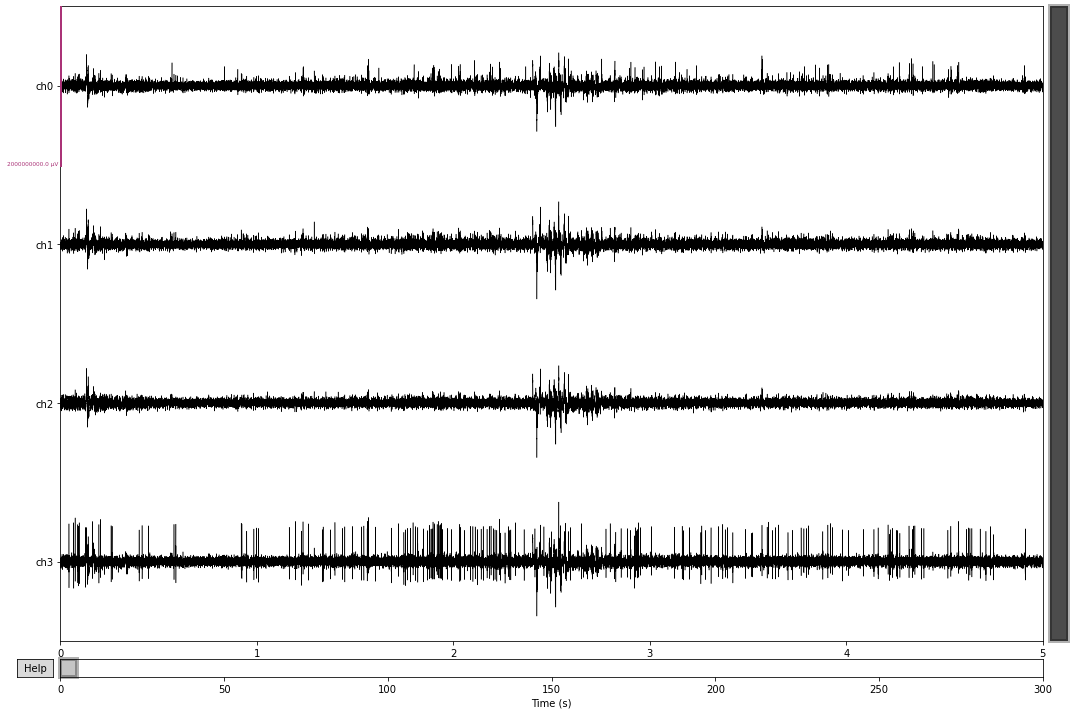

In [75]:
# set browser backend to matplotlib => no popup
mne.viz.set_browser_backend('matplotlib')
fig = mne.viz.plot_raw(
    dset_mne,
    start=0,
    duration = 5,
    show=False,
    scalings={'eeg':1000})


fig.set_size_inches(15,10)

Plot PSD of raw data

Effective window size : 0.082 (s)


/tmp/ipykernel_11717/2290661222.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = dset_mne.plot_psd(show=False)


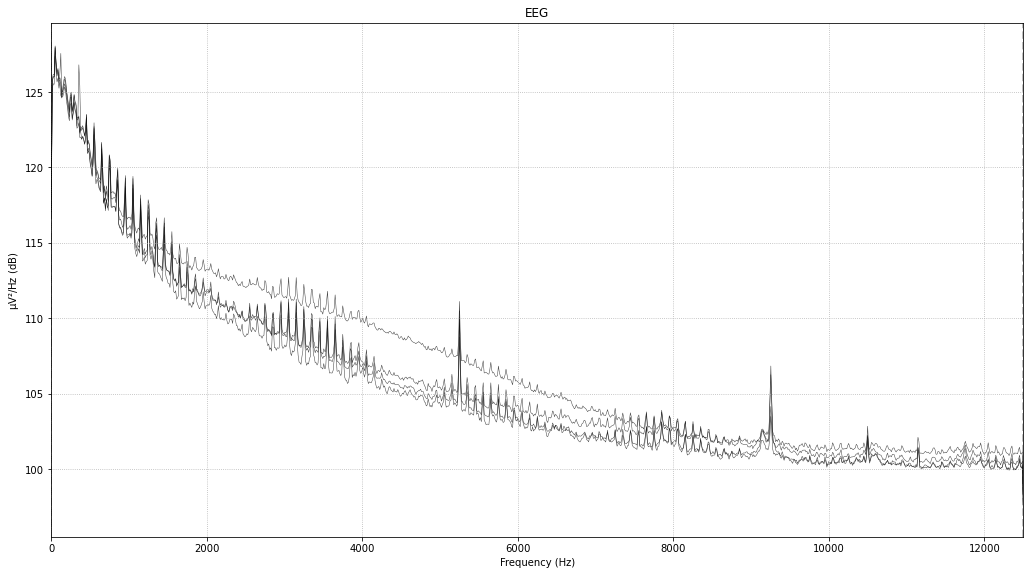

In [76]:
fig = dset_mne.plot_psd(show=False)
fig.set_size_inches(15,10)

Re-reference the data to common median

In [77]:
dset_mne_ref = mne.io.RawArray(dset[:]-np.median(dset[:],axis=0)[None,:],
                           dset_info)

Creating RawArray with float64 data, n_channels=4, n_times=7500000
    Range : 0 ... 7499999 =      0.000 ...   300.000 secs
Ready.


Opening raw-browser...


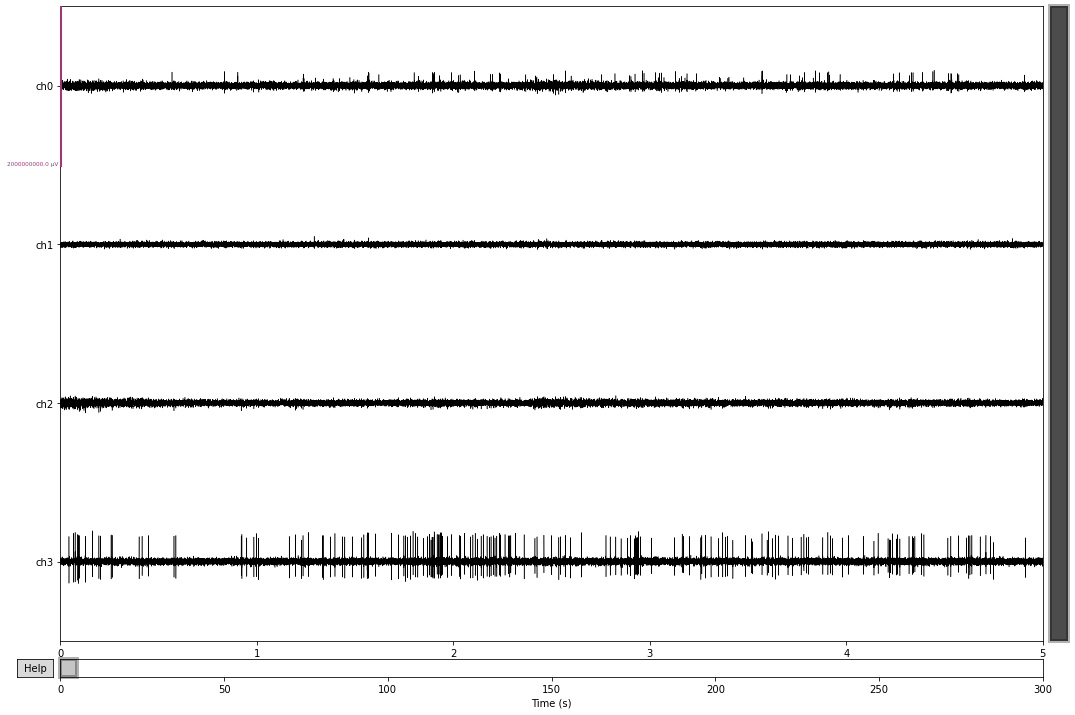

In [78]:
fig = mne.viz.plot_raw(
    dset_mne_ref,
    start=0,
    duration = 5,
    show=False,
    scalings={'eeg':1000})
fig.set_size_inches(15,10)

Plot psd of median referenced data

Effective window size : 0.082 (s)


/tmp/ipykernel_11717/729340552.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = dset_mne_ref.plot_psd(show=False)


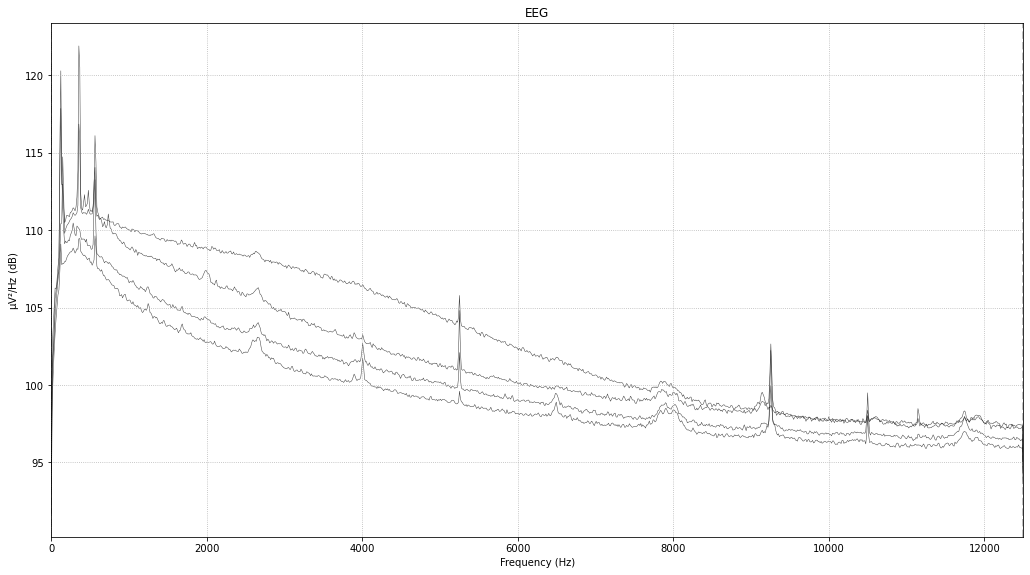

In [79]:
fig = dset_mne_ref.plot_psd(show=False)
fig.set_size_inches(15,10)

### Plot single spikes

Plot only channel 3, first second

Opening raw-browser...


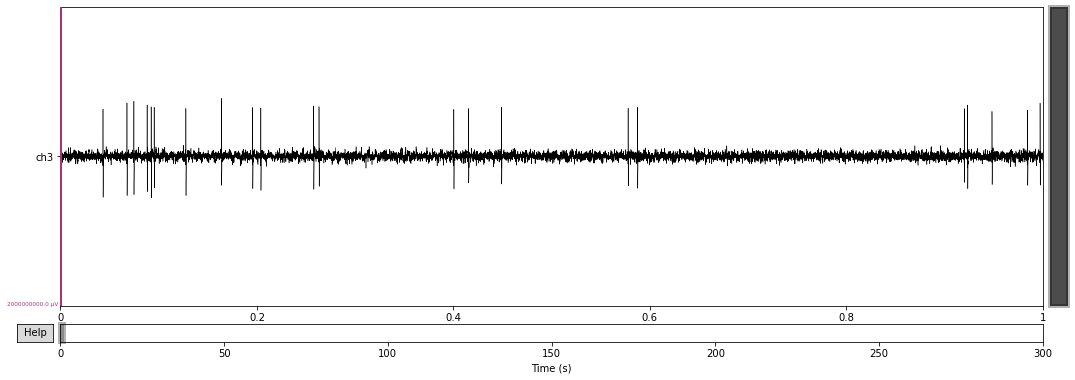

In [80]:
fig = mne.viz.plot_raw(
    dset_mne_ref.copy().pick_channels(['ch3']),
    start=0,
    duration = 1,
    show=False,
    scalings={'eeg':1000})
fig.set_size_inches(15,5)

Plot only channel 3, 80-100 ms

Opening raw-browser...


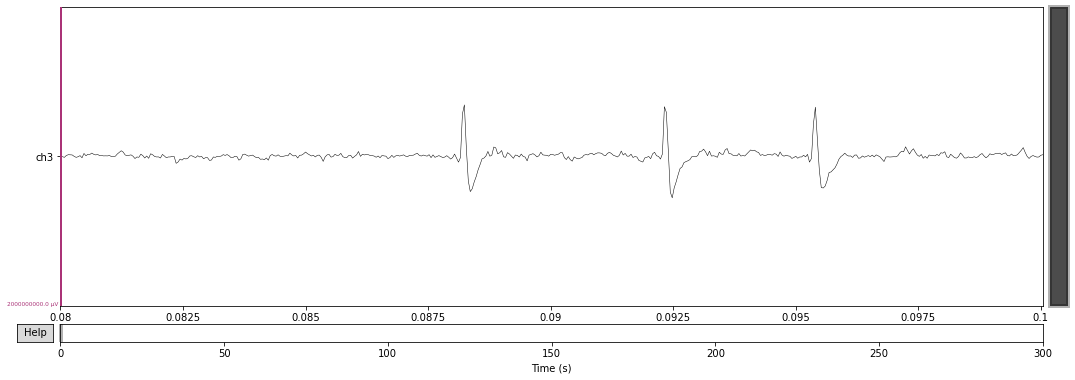

In [81]:
fig = mne.viz.plot_raw(
    dset_mne_ref.copy().pick_channels(['ch3']),
    start=0.08,
    duration = 0.02,
    show=False,
    scalings={'eeg':1000})
fig.set_size_inches(15,5)

In [82]:
dset_mne_reffilt = dset_mne_ref.copy().filter(l_freq=300,h_freq = 6000)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3e+02 - 6e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 300.00
- Lower transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 262.50 Hz)
- Upper passband edge: 6000.00 Hz
- Upper transition bandwidth: 1500.00 Hz (-6 dB cutoff frequency: 6750.00 Hz)
- Filter length: 1101 samples (0.044 sec)



Opening raw-browser...


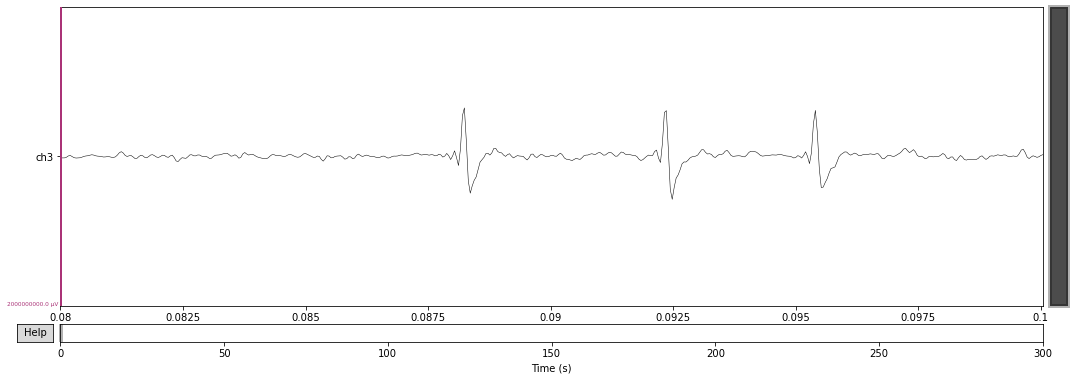

In [83]:
fig = mne.viz.plot_raw(
    dset_mne_reffilt.copy().pick_channels(['ch3']),
    start=0.08,
    duration = 0.02,
    show=False,
    scalings={'eeg':1000})
fig.set_size_inches(15,5)

### Perform spike-sorting

Different approaches and algorithms for Spike Sorting. Here, we use SpikeInterface:
* Python-package: https://spikeinterface.readthedocs.io
* Publication: *Buccino, A. P., Hurwitz, C. L., Garcia, S., Magland, J., Siegle, J. H., Hurwitz, R., & Hennig, M. H. (2020). SpikeInterface, a unified framework for spike sorting. ELife, 9, e61834. https://doi.org/10.7554/eLife.61834*
* Advantages of the the package: it implements different types of algorithms




In [84]:
import spikeinterface.full as ss

Create a spikeinterface recording object

In [85]:
num_channels = 4
sampling_frequency = 25000  # in Hz
num_segments = 1
recording = ss.NumpyRecording(traces_list=[dset.T], sampling_frequency=sampling_frequency)

Plot first 5 seconds of data

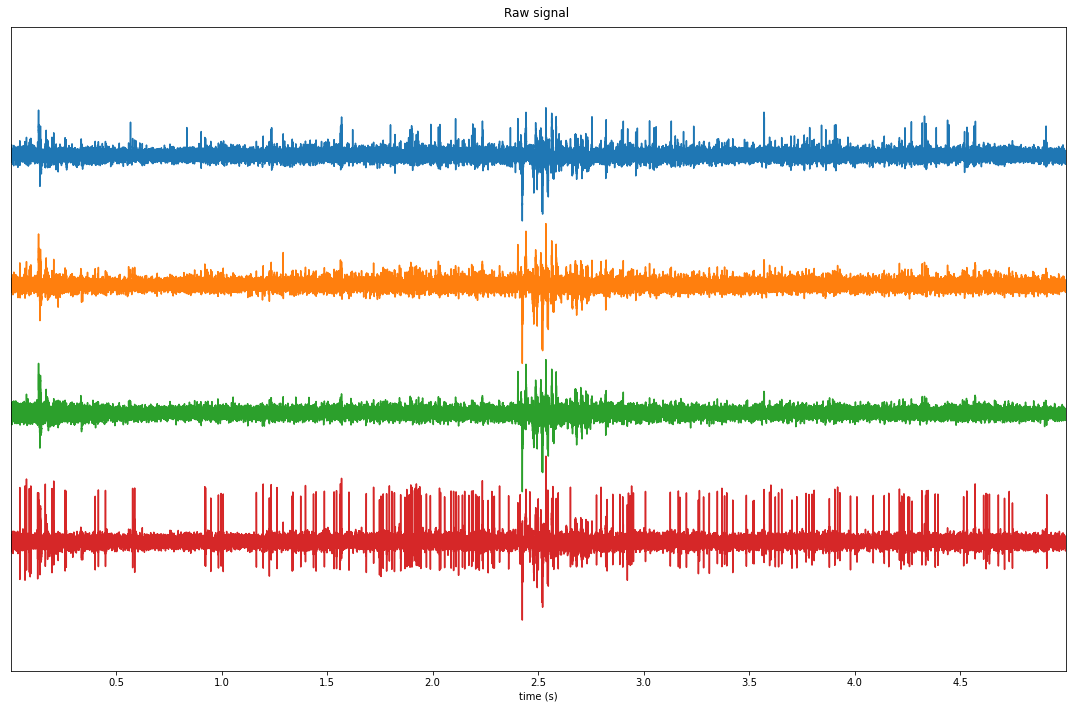

In [86]:
#%% Plot first 5 seconds
w_ts = ss.plot_timeseries(recording, time_range=(0, 5))
fig = plt.gcf()
fig.set_size_inches(15,10)
fig.suptitle('Raw signal')
fig.tight_layout()

Preprocess the data:
* Bandpass-filter the data: 300-6000 Hz
* Re-reference to common median

In [87]:
# Filter the recording
recording_flt = ss.bandpass_filter(recording,freq_min=300, freq_max=6000)

# Re-reference
recording_fltref = ss.common_reference(recording_flt,reference='global',operator='median')

Plot the processed data
* The channel appear to have different amplitudes ...

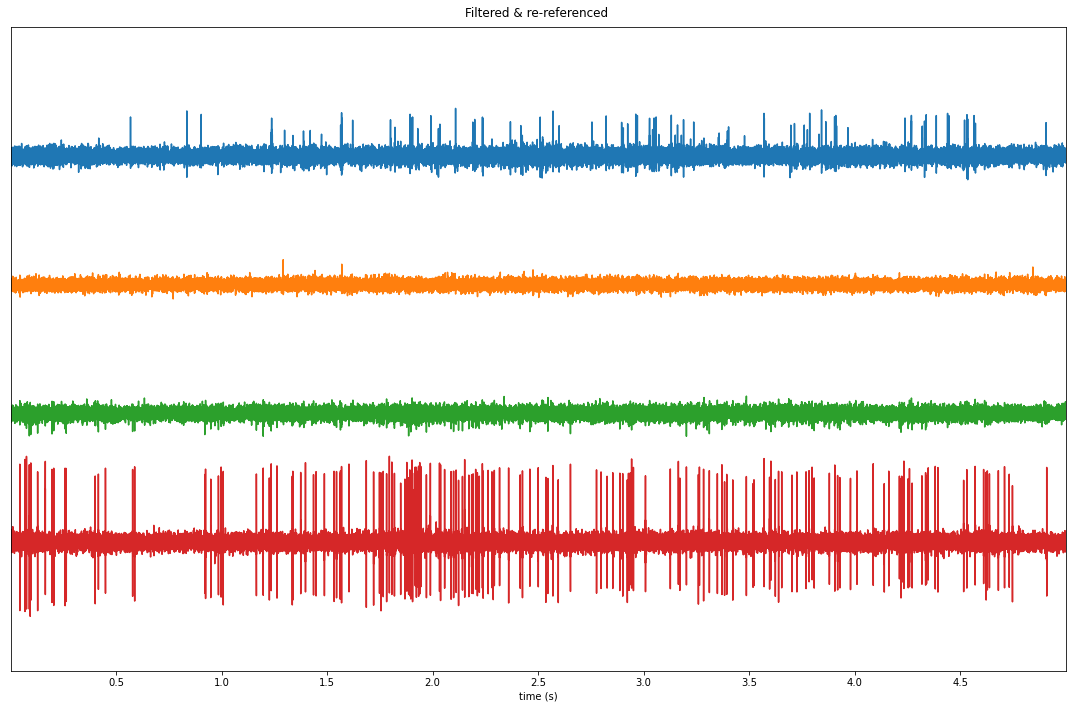

In [88]:
# Plot
w_ts = ss.plot_timeseries(recording_fltref, time_range=(0, 5))

fig = plt.gcf()
fig.set_size_inches(15,10)
fig.suptitle('Filtered & re-referenced')
fig.tight_layout()

Pick a channel for spike-sorting
 
Note: spike sorting can be performed for multiple channels. It is even possible to try to identify units that are visible in multiple channels (if electrodes were placed close to each other)

In [113]:
recording_fltref_chn = recording_fltref.channel_slice([0])

Define the electrode ("probe") that was used:
* assume a linear electrode with 1 channel
* plot it

(<matplotlib.collections.PolyCollection at 0x7f05af0d3a60>,
 <matplotlib.collections.PolyCollection at 0x7f05af0e8d60>)

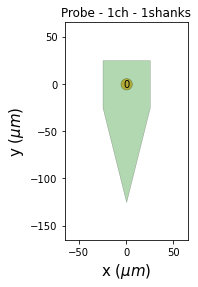

In [114]:
from probeinterface import  generate_linear_probe

from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import Probe, ProbeGroup

# create probe
linear_probe = generate_linear_probe(num_elec=1, ypitch=20)
linear_probe.set_device_channel_indices(0)


plot_probe(linear_probe, with_channel_index=True)

Assign probe to recording

In [115]:
recording_fltref_chn = recording_fltref_chn.set_probe(linear_probe)

Save recording (required for sorting)

In [116]:
recording_preprocessed = recording_fltref_chn.save(format='binary')

Use cache_folder=/tmp/spikeinterface_cache/tmp6f0tpjvj/T14XNWTJ
write_binary_recording with n_jobs 1  chunk_size None


Run sorter:
* Use the preprocessd recording
* Use the Tridesclous (TDC) sorting algorithm (https://tridesclous.readthedocs.io)

In [117]:
sorting_TDC = ss.run_sorter(sorter_name = 'tridesclous',
                             recording=recording_preprocessed)

Report the result: hot many units?

In [118]:
print(sorting_TDC)

TridesclousSortingExtractor: 2 units - 1 segments - 25.0kHz


Extract the waveforms of all units

In [119]:
we_TDC = ss.WaveformExtractor.create(recording_preprocessed,
                                     sorting_TDC, 'waveforms',
                                     remove_if_exists=True)
we_TDC.set_params(ms_before=3., ms_after=4., max_spikes_per_unit=500)
we_TDC.run_extract_waveforms(n_jobs=-1, chunk_size=30000)

### Report sorting results

Plot the waveforms of all units

Text(0.5, 0.98, 'Waveforms of units')

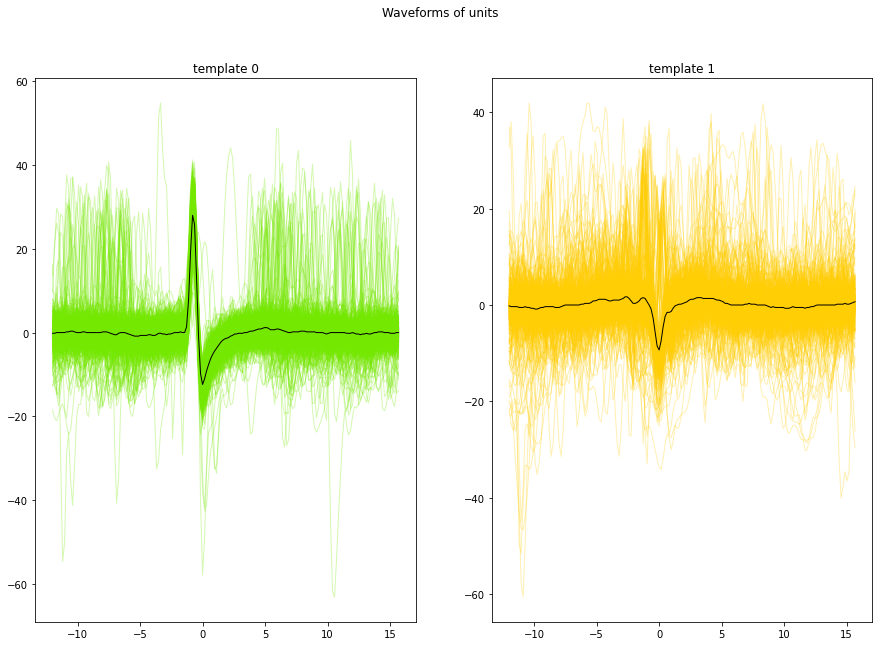

In [120]:
ss.plot_unit_waveforms(we_TDC,unit_ids = sorting_TDC.unit_ids[:])

fig = plt.gcf()
fig.set_size_inches(15,10)
fig.suptitle('Waveforms of units')

Text(0.5, 0.98, 'Mean waveforms')

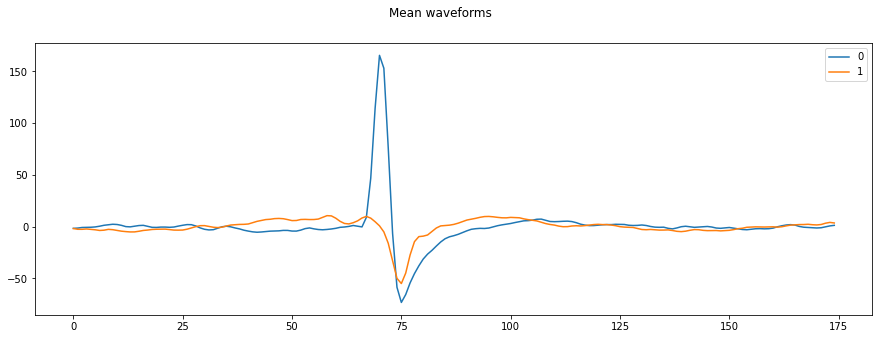

In [121]:
fig, ax = plt.subplots(figsize=(15,5))

for Ui in range(len(sorting_TDC.unit_ids)):
    ax.plot(np.mean(we_TDC.get_waveforms(Ui),axis=0),label=str(Ui))

ax.legend()
fig.suptitle('Mean waveforms')    

Plot the activity of the units

Text(0.5, 0.98, 'Single spikes in time per unit')

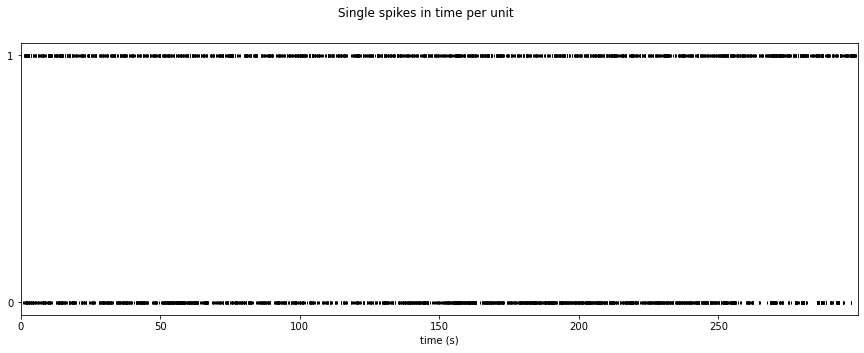

In [122]:
ss.plot_rasters(sorting_TDC)
fig = plt.gcf()
fig.set_size_inches(15,5)
fig.suptitle('Single spikes in time per unit')

Text(0.5, 0.98, 'Spiking activity in time as density')

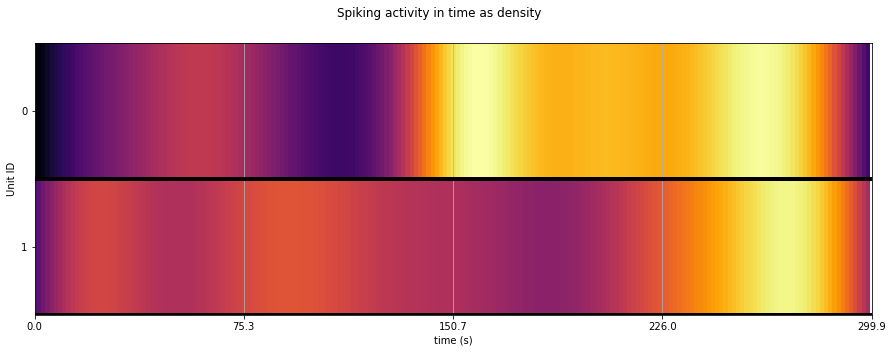

In [123]:
ss.plot_presence(sorting_TDC)
fig = plt.gcf()
fig.set_size_inches(15,5)
fig.suptitle('Spiking activity in time as density')

Plot auto- and cross-correlogram

Text(0.5, 0.98, 'Auto-and Cross-correlogram')

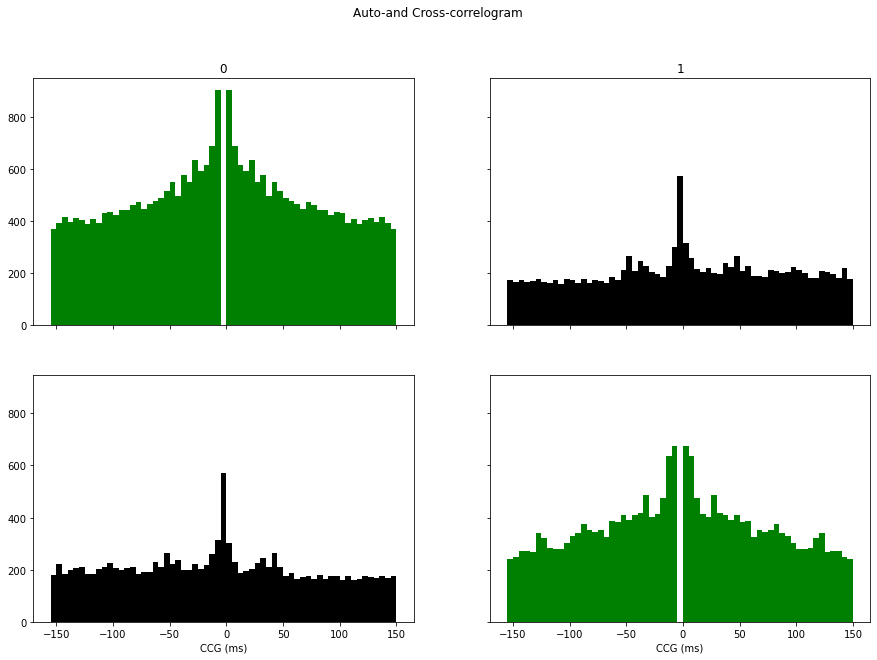

In [124]:
ss.plot_crosscorrelograms(sorting_TDC, window_ms=300.0, bin_ms=5.0, symmetrize=True)

fig = plt.gcf()
fig.set_size_inches(15,10)
fig.suptitle('Auto-and Cross-correlogram')


Assignment: what kind of information do the auto- and cross-correlograms represent?